In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from matplotlib.image import imread
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection
import matplotlib.colors as colors
warnings.filterwarnings('ignore')
%matplotlib inline

In [23]:
df = pd.read_csv('C:/Users/caiji/Desktop/archive/mm_master_demos.csv', index_col=0)
map_bounds = pd.read_csv('C:/Users/caiji/Desktop/archive/map_data.csv', index_col=0)
#pd.set_option('display.max_columns', None)
#print(df.head(20))

In [24]:
active_duty_maps = ['de_cache', 'de_cbble', 'de_dust2', 'de_inferno', 'de_mirage', 'de_overpass', 'de_train']
df = df[df['map'].isin(active_duty_maps)]  #将原始数据DataFrame df中的'map'列，进行判断筛选，只保留属于Active Duty地图的行数据
df = df.reset_index(drop=True)  #重置DataFrame的索引，保留新的索引作为DataFrame的行索引
md = map_bounds.loc[df['map']]  #这里使用之前提到的map_bounds数据集，并基于比赛数据集中的地图名称来选择相应的地图边界数据。

md[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']] = (df.set_index('map')[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']])
#这里将比赛数据集中的攻击者和受害者的坐标数据与地图边界数据合并。首先，将比赛数据集按地图名称进行索引，
# 然后选择攻击者和受害者的坐标数据，最后将它们赋值给地图边界数据中的相应列。


md['att_pos_x'] = (md['ResX']*(md['att_pos_x']-md['StartX']))/(md['EndX']-md['StartX'])
md['att_pos_y'] = (md['ResY']*(md['att_pos_y']-md['StartY']))/(md['EndY']-md['StartY'])
md['vic_pos_x'] = (md['ResX']*(md['vic_pos_x']-md['StartX']))/(md['EndX']-md['StartX'])
md['vic_pos_y'] = (md['ResY']*(md['vic_pos_y']-md['StartY']))/(md['EndY']-md['StartY'])
df[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']] = md[['att_pos_x', 'att_pos_y', 'vic_pos_x', 'vic_pos_y']].values
#图像坐标系转换到真实物理空间坐标系

In [25]:
avail_pistols = ['USP', 'Glock', 'P2000', 'P250', 'Tec9', 'FiveSeven', 'Deagle', 'DualBarettas', 'CZ'] #列出所有手枪名称

df_pistol = df[(df['round'].isin([1,16])) & (df['wp'].isin(avail_pistols))] #筛选1、16局中所有使用手枪的伤害条目
print("Total Number of Pistol Rounds: %i" % df_pistol.groupby(['file', 'round'])['tick'].first().count()) #将df以两个维度进行划分提取手枪局数
print("Total Number of normal Rounds: %i" % df.groupby(['file', 'round'])['tick'].first().count())

Total Number of Pistol Rounds: 2470
Total Number of normal Rounds: 31532


In [26]:
pistol_buys = df_pistol.groupby(['file', 'round', 'att_side', 'wp'])['hp_dmg'].first() #将手枪局中第一次使用武器攻击对方作为频率指标计数
pistol_counts = (pistol_buys.groupby(['wp']).count()/pistol_buys.groupby(['wp']).count().sum())*100 #某武器出现次数/全部手枪出现次数

# 同上，计算包括手枪在内所有武器
normal_buys = df.groupby(['file', 'round', 'att_side', 'wp'])['hp_dmg'].first()
gun_counts = (normal_buys.groupby(['wp']).count() / normal_buys.groupby(['wp']).count().sum()) * 100

# 对频率进行排序
sort_gun_counts = gun_counts.sort_values(ascending=False)
sort_pistol_counts = pistol_counts.sort_values(ascending=False)
# 获取枪支列表
pistol_names = sort_pistol_counts.index
pistol_frequency = sort_pistol_counts.values
weapon_names = sort_gun_counts.index
weapon_frequency = sort_gun_counts.values

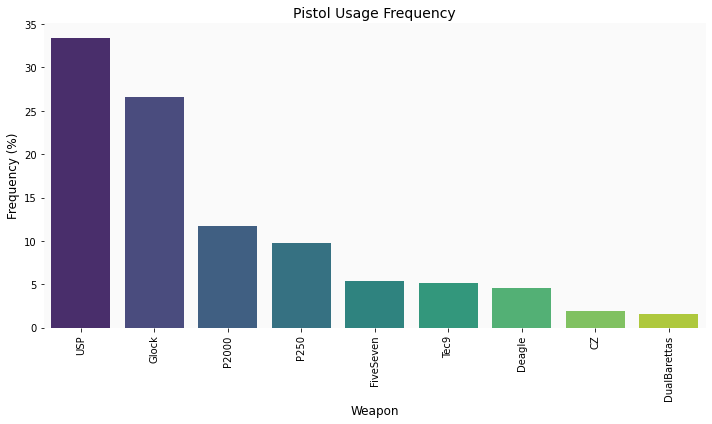

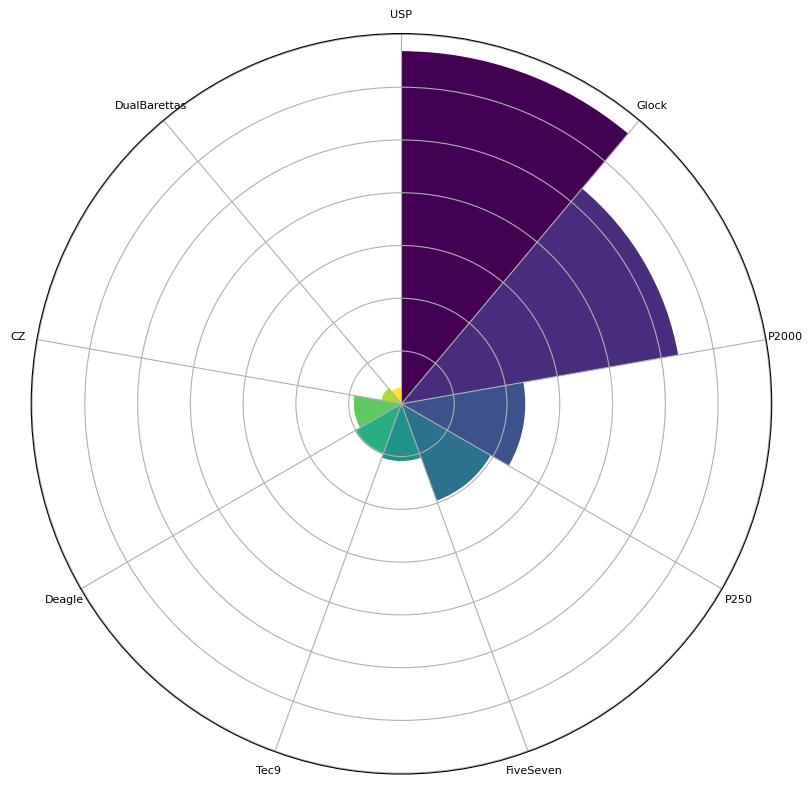

In [27]:
# 创建一个颜色映射
colors = sns.color_palette('viridis', len(sort_pistol_counts))
# 绘制直方图
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sort_pistol_counts.index, y=sort_pistol_counts, palette=colors)
# 添加阴影效果
sns.despine(top=True, right=True, left=True, bottom=True)  # 去除轴线
plt.gca().set_axisbelow(True)  # 将阴影放在底层
plt.gca().patch.set_alpha(0.3)  # 设置整个图形的透明度
# 设置坐标轴标签和标题
plt.xlabel('Weapon', fontsize=12)
plt.ylabel('Frequency (%)', fontsize=12)
plt.title('Pistol Usage Frequency', fontsize=14)
# 旋转x轴刻度标签，以避免重叠
plt.xticks(rotation=90)
# 调整字体样式和大小
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# 添加背景颜色
plt.gca().set_facecolor('#f0f0f0')
# 调整布局，以防止标签被截断
plt.tight_layout()
# 显示图表
plt.show()


# 将枪支名称转换为数值标签
labels = range(len(pistol_names))
# 计算每个扇形的角度
angles = np.linspace(0, 2 * np.pi, len(pistol_names), endpoint=False).tolist()
# 绘制南丁格尔玫瑰图
fig = plt.figure(figsize=(12, 8), dpi=100)#调整大小
ax = fig.add_subplot(111, polar=True)
# 设置扇形宽度
width = np.pi * 2 / len(pistol_names)
# 绘制扇形
bars = ax.bar(angles, pistol_frequency, width=width, align='edge')
# 设置扇形颜色
colors = plt.cm.viridis(np.linspace(0, 1, len(pistol_names)))
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)
# 设置x轴标签为枪支名称，并斜向显示
ax.set_xticks(angles)
ax.set_xticklabels(pistol_names, fontsize=8, ha='center')
plt.xticks(rotation=60)
# 设置极坐标轴的角度范围
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
# 添加网格
ax.grid(True)
# 调整图形布局
plt.tight_layout()
# 显示图形
ax.set_yticklabels([])#为了美观去除刻度
plt.show()

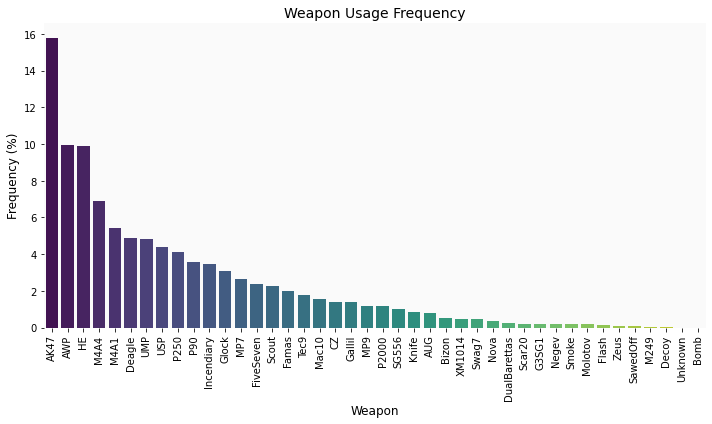

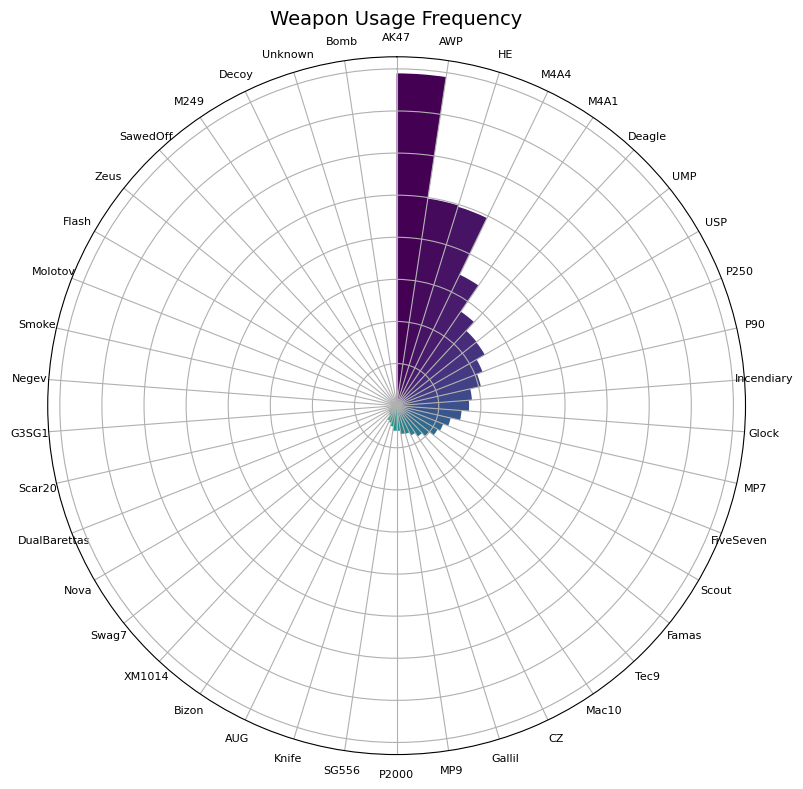

In [7]:
# 以相同方法创造直方图
colors = sns.color_palette('viridis', len(sort_gun_counts))
plt.figure(figsize=(10, 6))
ax = sns.barplot(x=sort_gun_counts.index, y=sort_gun_counts, palette=colors)
sns.despine(top=True, right=True, left=True, bottom=True) 
plt.gca().set_axisbelow(True)
plt.gca().patch.set_alpha(0.3)
plt.xlabel('Weapon', fontsize=12)
plt.ylabel('Frequency (%)', fontsize=12)
plt.title('Weapon Usage Frequency', fontsize=14)
plt.xticks(rotation=90)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.gca().set_facecolor('#f0f0f0')
plt.tight_layout()
plt.show()

#以下为相同方法展示所有枪支的南丁格尔玫瑰图
labels = range(len(weapon_names))
angles = np.linspace(0, 2 * np.pi, len(weapon_names), endpoint=False).tolist()
fig = plt.figure(figsize=(12, 8), dpi=100)#调整大小
ax = fig.add_subplot(111, polar=True)
width = np.pi * 2 / len(weapon_names)
bars = ax.bar(angles, weapon_frequency, width=width, align='edge')
colors = plt.cm.viridis(np.linspace(0, 1, len(weapon_names)))
for bar, color in zip(bars, colors):
    bar.set_facecolor(color)
ax.set_xticks(angles)
ax.set_xticklabels(weapon_names, fontsize=8, ha='center')
plt.xticks(rotation=45)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_title("Weapon Usage Frequency", fontsize=14)
ax.grid(True)
plt.tight_layout()
ax.set_yticklabels([])
plt.show()

Text(0.5, 1.0, 'bw=0.20')

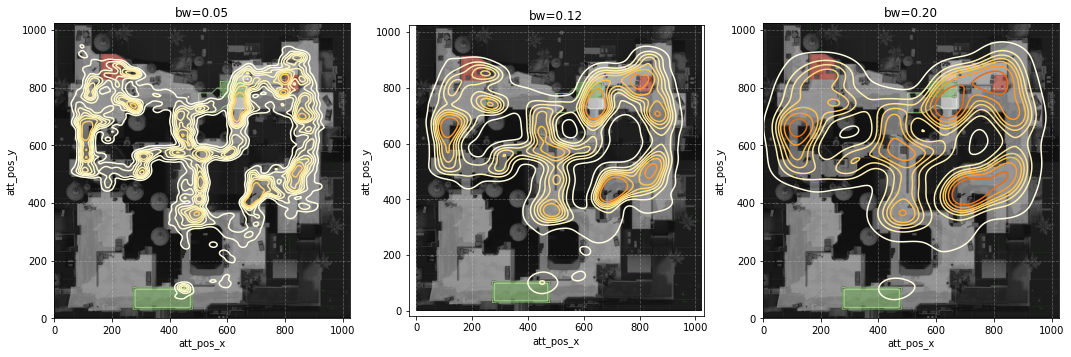

In [8]:
smap = 'de_dust2'

bg = imread('C:/Users/caiji/Desktop/archive/'+smap+'.png')
fig, (ax1, ax2 ,ax3) = plt.subplots(1,3,figsize=(18,16)) #创建一个figure对象和三个子图
ax1.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax2.grid(True, which='major', color='w', linestyle='--', alpha=0.25)#给三个子图添加网格线
ax3.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
ax2.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])#在三个子图上展示de_dust2地图的背景图片
ax3.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)#设置x轴和y轴的范围

plot_df = df_pistol.loc[(df_pistol.map == smap) & (df_pistol.att_side == 'Terrorist')]

sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.05,ax=ax1,n_levels=8)
ax1.set_title('bw=0.05')

sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.12,ax=ax2,n_levels=8)
ax2.set_title('bw=0.12')

sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.20,ax=ax3,n_levels=8)
ax3.set_title('bw=0.20')

Text(0.5, 1.0, 'CT')

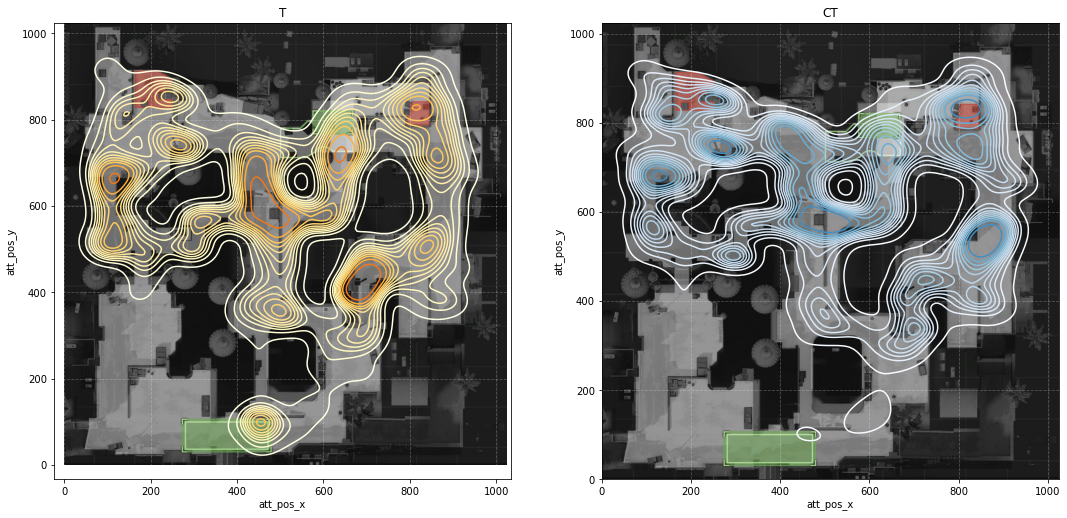

In [9]:
#这个为双方输出图对比
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(18,16))
ax1.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax2.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
ax2.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)

plot_df = df.loc[(df.map == smap) & (df.att_side == 'Terrorist')]
sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.12,ax=ax1,n_levels=12)
ax1.set_title('T')

plot_df = df.loc[(df.map == smap) & (df.att_side == 'CounterTerrorist')]
sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='Blues',bw=0.12,ax=ax2,n_levels=12)
ax2.set_title('CT')

Text(0.5, 1.0, 'AWP heat')

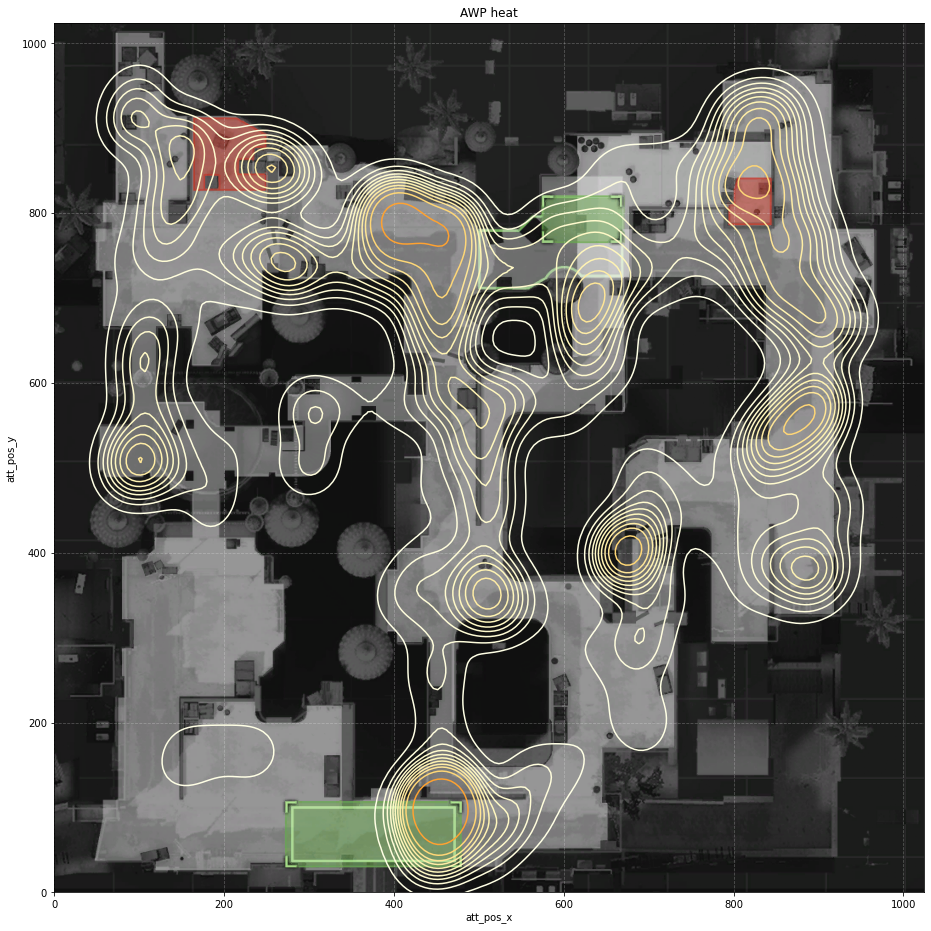

In [10]:
#这个为AWP输出图
fig, ax1 = plt.subplots(figsize=(18,16))
df_AWP = df[(df['wp'].isin(['AWP']))]
ax1.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)
plot_df = df_AWP.loc[(df_AWP.map == smap)]
sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.1,ax=ax1,n_levels=12)
ax1.set_title('AWP heat')


Text(0.5, 1.0, 'T')

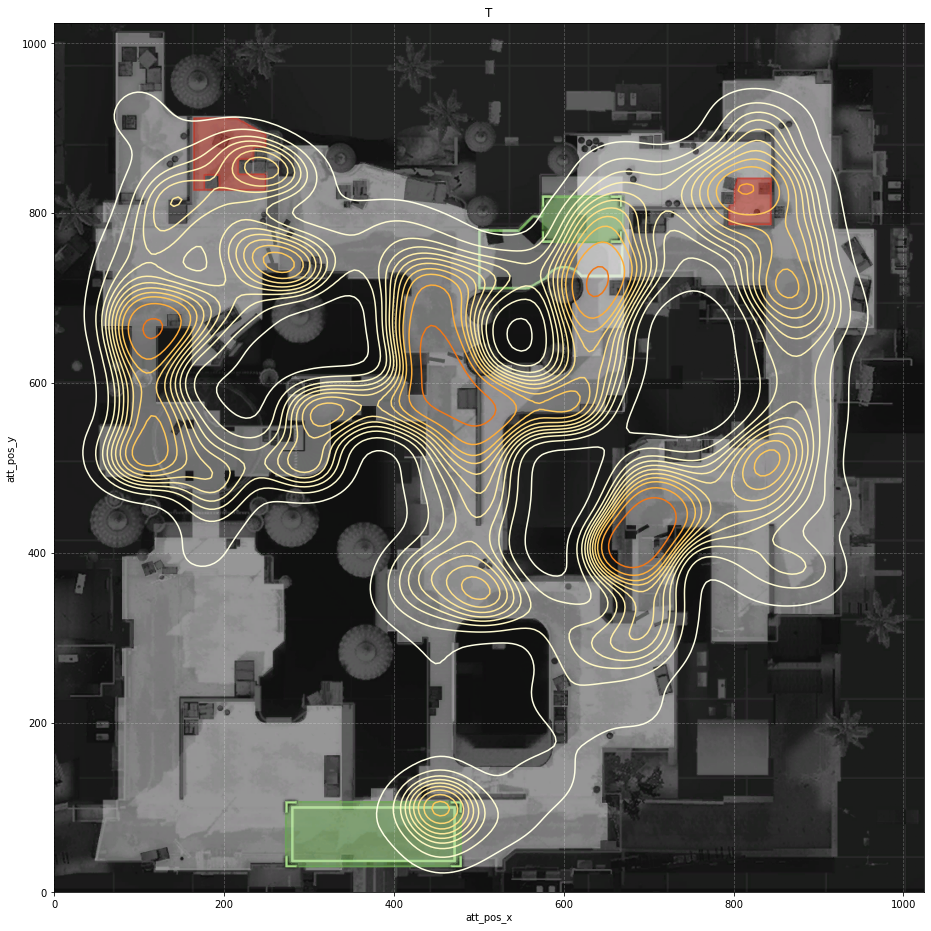

In [11]:
#这个为T阵营输出图
fig, ax1 = plt.subplots(figsize=(18,16))
ax1.grid(True, which='major', color='w', linestyle='--', alpha=0.25)
ax1.imshow(bg, zorder=0, extent=[0.0, 1024, 0., 1024])
plt.xlim(0,1024)
plt.ylim(0,1024)

plot_df = df.loc[(df.map == smap) & (df.att_side == 'Terrorist')]
sns.kdeplot(x=plot_df['att_pos_x'],y=plot_df['att_pos_y'],cmap='YlOrBr',bw=0.12,ax=ax1,n_levels=12)
ax1.set_title('T')


In [12]:
from collections import Counter
from collections import OrderedDict
hitboxs = df.hitbox.values #包含所有身体部位的列表
df_T = df.loc[df['is_bomb_planted'] == True] #筛选出炸弹已安装或未安装时的伤害条目
df_F = df.loc[df['is_bomb_planted'] == False]
#print(df_T)
#print(df_F.head(50))

T_list = df_T['hitbox'].tolist() #tolist讲dataframe去掉序号变为列表
F_list = df_F['hitbox'].tolist()
# 使用Counter进行计数
T_counts = Counter(T_list)
F_counts = Counter(F_list)

# 按照值的大小将字典排序
T_counts = dict(sorted(T_counts.items(), key=lambda x: x[1], reverse=True))
F_counts = dict(sorted(F_counts.items(), key=lambda x: x[1], reverse=True))
# 获取身体部位和计数
Tbody_parts = list(T_counts.keys())
Tcounts = list(T_counts.values())
Fbody_parts = list(F_counts.keys())
Fcounts = list(F_counts.values())

# 定义自定义颜色，这里使用渐变紫色系
colors = ['#b39ddb', '#9575cd', '#7e57c2', '#673ab7', '#5e35b1', '#512da8', '#4527a0', '#311b92']


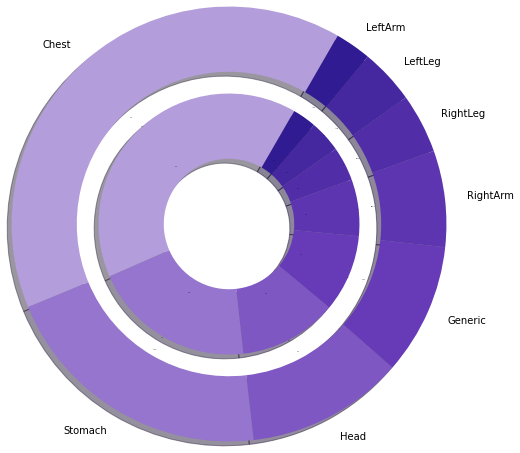

In [13]:
import matplotlib.patches as patches
# 创建画布和子图
fig, ax = plt.subplots()
# 内环大小参数
inner_radius = 0.6
# 绘制内环饼图
#Tcounts：内环饼图的数据，即各个部位的计数值。
#labels=Tbody_parts：内环饼图的标签，即各个部位的名称。
#autopct='%1.1f%%'：设置百分比值的显示格式。
#startangle=90：设置起始角度。
#colors=colors：设置扇形块的颜色。
#radius=inner_radius：设置内环的半径大小。
#wedgeprops=dict(width=0.3)：设置扇形块的宽度，这里将其设置为0.3表示内环
wedges_inner, texts_inner, autotexts_inner = ax.pie(Tcounts, labels=Tbody_parts, autopct='%1.1f%%', startangle=60, colors=colors, radius=inner_radius, wedgeprops=dict(width=0.3),shadow=True)

# 外环大小参数
outer_radius = 1.0

# 绘制外环饼图
wedges_outer, texts_outer, autotexts_outer = ax.pie(Fcounts, labels=Fbody_parts, autopct='%1.1f%%', startangle=60, colors=colors, radius=outer_radius, wedgeprops=dict(width=0.3),shadow=True)


# 调整字体大小，美观为主
for text in autotexts_inner:
    text.set_fontsize(0)
for text in autotexts_outer:
    text.set_fontsize(0)
for text in texts_inner:
    text.set_fontsize(10)
for text in texts_inner:
    text.set_fontsize(0)

# 设置内环饼图的中心位置
ax.set(aspect="equal")
ax.set_xlim([-0.5, 0.5])
ax.set_ylim([-0.5, 0.5])

# 显示图表
plt.show()


In [14]:
# 统计每个包点的下包次数
bomb_site_counts = df.groupby(['file', 'round'])['bomb_site'].first()
bomb_site_c = bomb_site_counts.value_counts(dropna=False)#计算空值


df_site_exist = df[df['bomb_site'].notnull()]#计算包点值不为空
bomb_site_wincount = df_site_exist.groupby(['file', 'round'])['bomb_site'].first()
bomb_site_winrates = df_site_exist.groupby(['file', 'round'])['winner_side'].first()
# 创建新的DataFrame
merged_df = pd.concat([bomb_site_wincount, bomb_site_winrates], axis=1)
# 设置列名
#shape[0]返回的是该对象的行数
merged_df.columns = ['bomb_site', 'winner_side'] 
count_A_T = merged_df.loc[(merged_df['bomb_site'] == 'A') & (merged_df['winner_side'] == 'Terrorist')].shape[0]
count_B_T = merged_df.loc[(merged_df['bomb_site'] == 'B') & (merged_df['winner_side'] == 'Terrorist')].shape[0]
count_B_CT = merged_df.loc[(merged_df['bomb_site'] == 'B') & (merged_df['winner_side'] == 'CounterTerrorist')].shape[0]
count_A_CT = merged_df.loc[(merged_df['bomb_site'] == 'A') & (merged_df['winner_side'] == 'CounterTerrorist')].shape[0]
print("Site A - T Count:", count_A_T)
print("Site B - T Count:", count_B_T)
print("Site B - CT Count:", count_B_CT)
print("Site A - CT Count:", count_A_CT)



# 统计每个回合内的安装炸弹次数
bomb_site_counts = df.groupby(['file', 'round'])['bomb_site'].count()
# 筛选出只有未安装炸弹的回合
no_bomb_rounds = bomb_site_counts[bomb_site_counts == 0]
# 根据回合获取对应的胜利方
winner_side = df.groupby(['file', 'round'])['winner_side'].first()
# 计算未安装炸弹的回合中CT和T的胜率
nobomb_CT = (winner_side.loc[no_bomb_rounds.index] == 'CounterTerrorist').sum()
nobomb_T = (winner_side.loc[no_bomb_rounds.index] == 'Terrorist').sum()
# 打印结果
print("NOBOMB - CT Count:", nobomb_CT)
print("NOBOMB - T Count:", nobomb_T)




Site A - T Count: 6685
Site B - T Count: 5301
Site B - CT Count: 1699
Site A - CT Count: 1897
NOBOMB - CT Count: 11546
NOBOMB - T Count: 4404


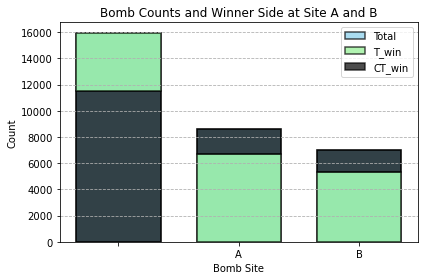

In [15]:
# 将索引对象转换为列表
x_labels = bomb_site_c.index.tolist()
x_ticks = np.arange(len(x_labels))

# 设置柱状图的宽度
bar_width = 0.7

# 绘制直方图
plt.bar(x_ticks, bomb_site_c, width=bar_width, alpha=0.7, color='skyblue', edgecolor='black', linewidth=1.5, label='Total')
plt.bar(x_ticks[:2] + 1.0, [count_A_T, count_B_T], width=bar_width, alpha=0.7, color='lightgreen', edgecolor='black', linewidth=1.5, label='T_win')
plt.bar(x_ticks[:2] + 1.0, [count_A_CT, count_B_CT], width=bar_width, alpha=0.7, color='black', edgecolor='black', linewidth=1.5, label='CT_win',bottom=[count_A_T, count_B_T])


plt.bar(x_ticks[:1], [nobomb_CT], width=bar_width, alpha=0.7, color='black', edgecolor='black', linewidth=1.5)
plt.bar(x_ticks[:1], [nobomb_T], width=bar_width, alpha=0.7, color='lightgreen', edgecolor='black', linewidth=1.5,bottom=[nobomb_CT])

# 调整x轴刻度标签的位置
plt.xticks(x_ticks , x_labels)
# 添加标题和标签，并设置字体样式
plt.title('Bomb Counts and Winner Side at Site A and B')
plt.xlabel('Bomb Site')
plt.ylabel('Count')
# 添加图例，并设置字体样式
plt.legend()
# 显示网格线
plt.grid(axis='y', linestyle='--')
# 调整图形边界
plt.tight_layout()
# 显示图表
plt.show()



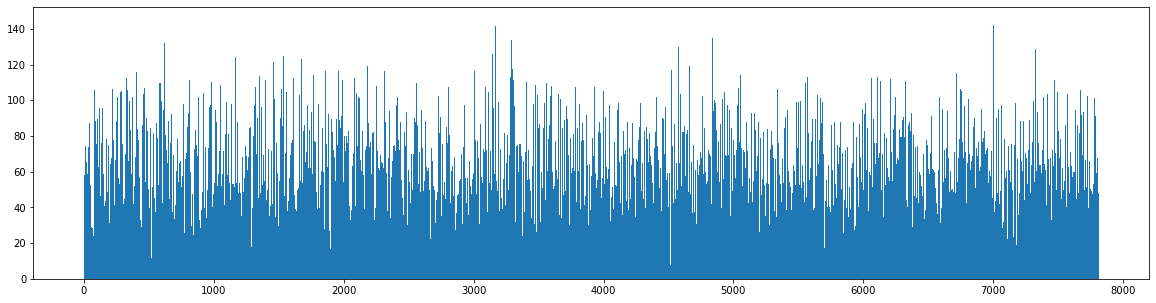

In [16]:
#dust2地图的每回合时间柱状图展示（是伤害时间）
df_dust = df.loc[(df.map == 'de_dust2')]
df_time_start = df_dust.groupby(['file', 'round'])["seconds"].first()#获取每回合最初伤害时间
df_time_last = df_dust.groupby(['file', 'round'])["seconds"].last()#获取每回合最末伤害时间
df_time = df_time_last - df_time_start
df_time = df_time.tolist()

sequence = [i for i in range(1, len(df_time) + 1)]#创造一个1到len（df_time）长度的序列

plt.figure(figsize=(20, 5))
plt.bar(sequence,df_time,width=2)

plt.show()

<AxesSubplot:xlabel='map', ylabel='seconds'>

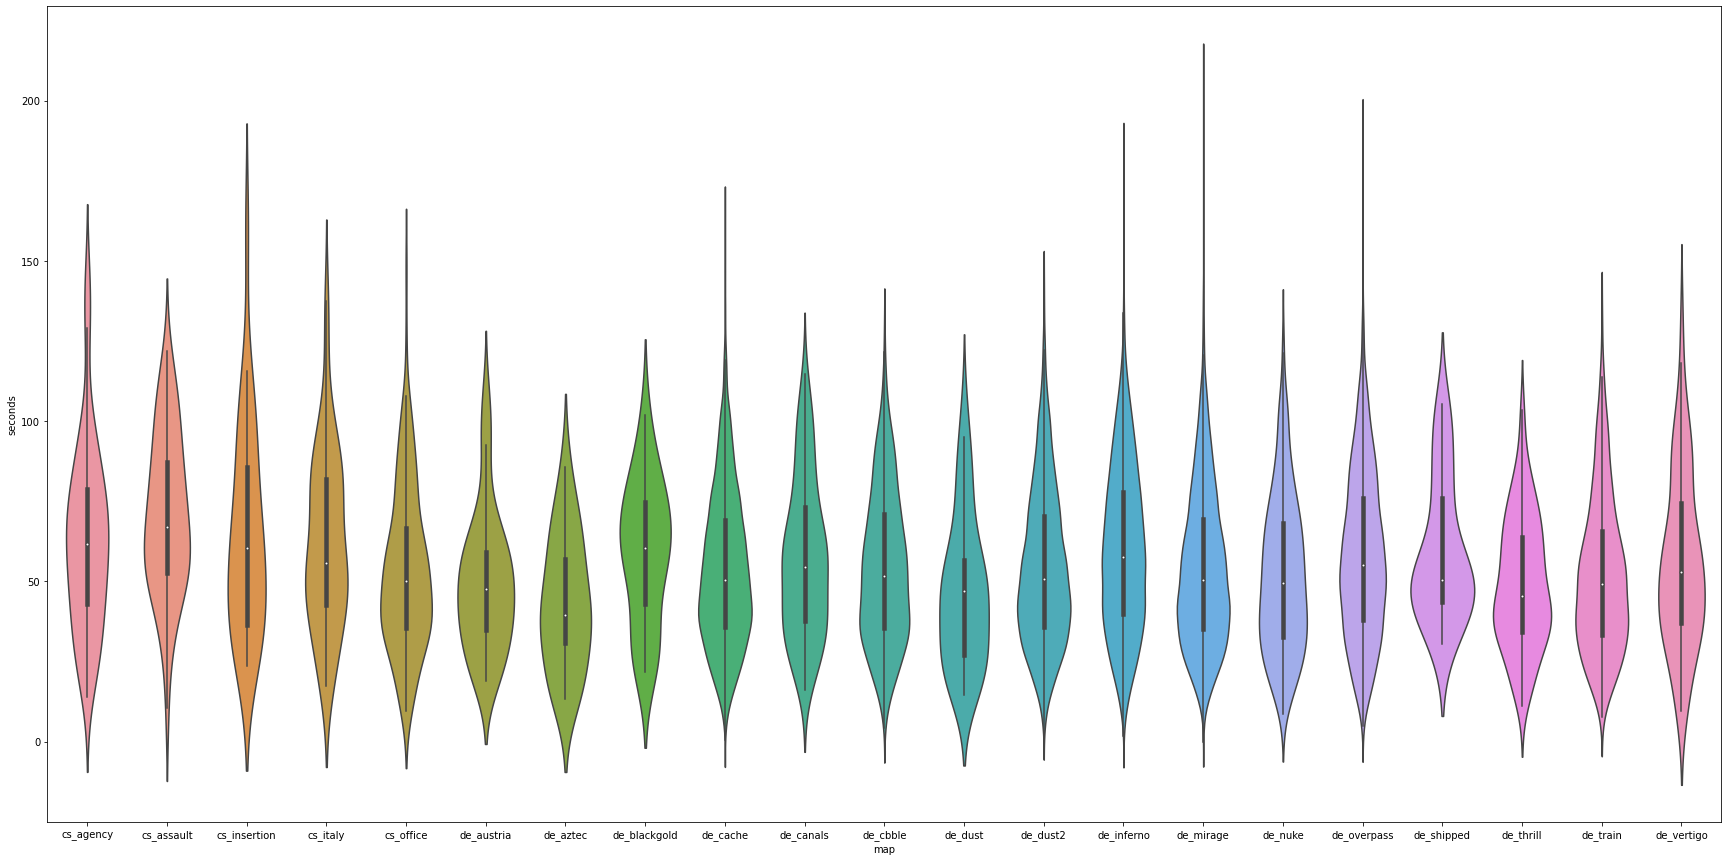

In [16]:
df = pd.read_csv('C:/Users/caiji/Desktop/archive/mm_master_demos.csv', index_col=0)
df_time_start = df.groupby(['map','file', 'round'])["seconds"].first()#获取每回合最初伤害时间
df_time_last = df.groupby(['map','file', 'round'])["seconds"].last()#获取每回合最末伤害时间
df_time = df_time_last - df_time_start
df_time_df = df_time.reset_index()#创建df以绘制violent
plt.figure(figsize=(30, 15))
sns.violinplot(x="map",y="seconds",data=df_time_df)


<AxesSubplot:xlabel='map', ylabel='seconds'>

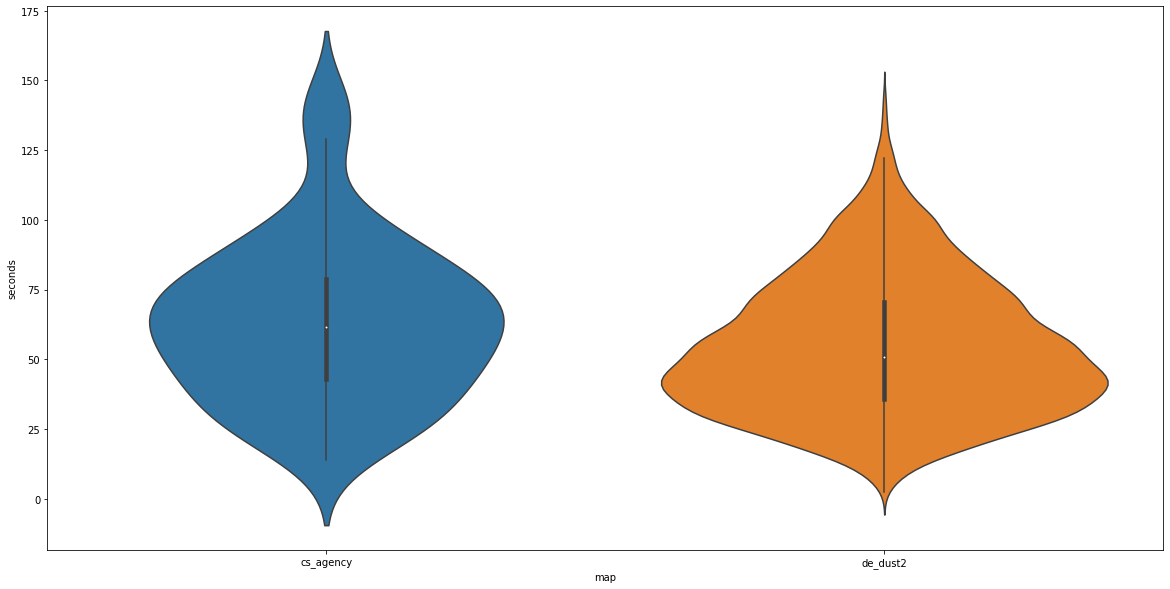

In [17]:
maps = ['de_dust2','cs_agency']
dff = df[df['map'].isin(maps)]  #将原始数据DataFrame df中的'map'列，进行判断筛选，只保留属于maps地图的行数据
dff_time_start = dff.groupby(['map','file', 'round'])["seconds"].first()#获取每回合最初伤害时间
dff_time_last = dff.groupby(['map','file', 'round'])["seconds"].last()#获取每回合最末伤害时间
dff_time = dff_time_last - dff_time_start
dff_time_df = dff_time.reset_index()#创建df以绘制violent
plt.figure(figsize=(20, 10))
sns.violinplot(x="map",y="seconds",data=dff_time_df)

<AxesSubplot:xlabel='map', ylabel='seconds'>

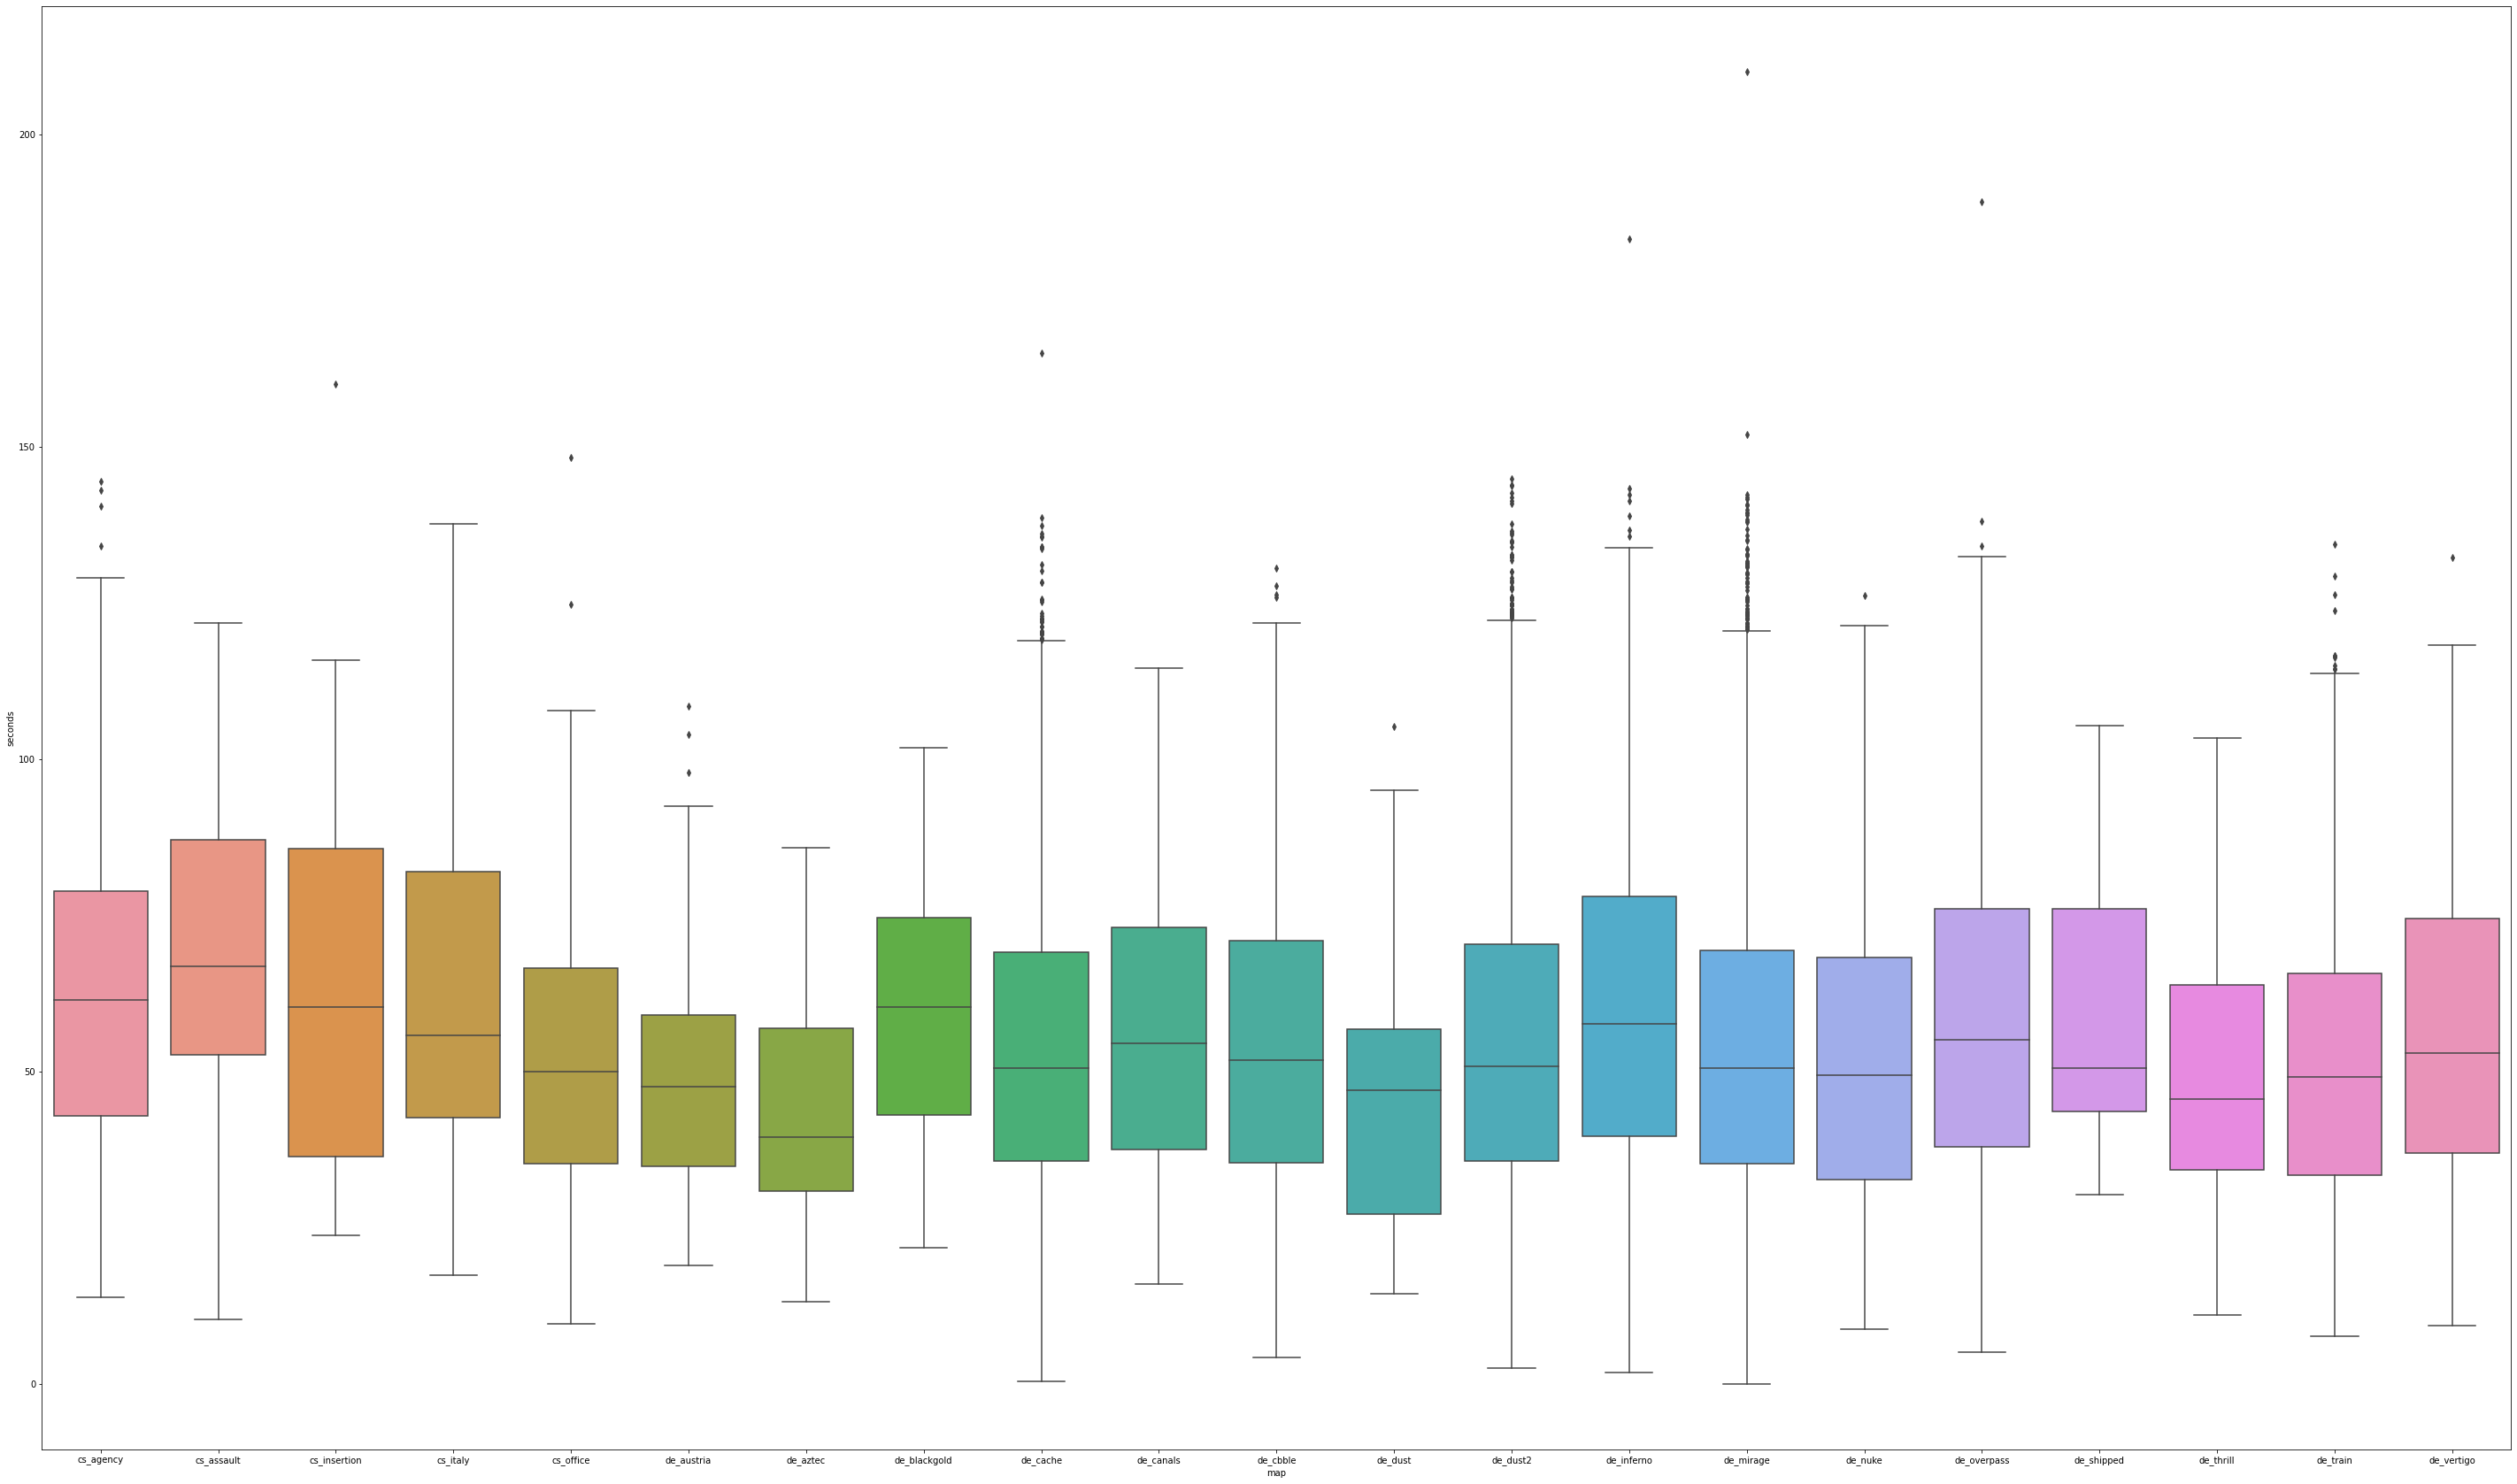

In [18]:
#箱型图
plt.figure(figsize=(50, 30))

sns.boxplot(x="map",y="seconds",data=df_time_df)

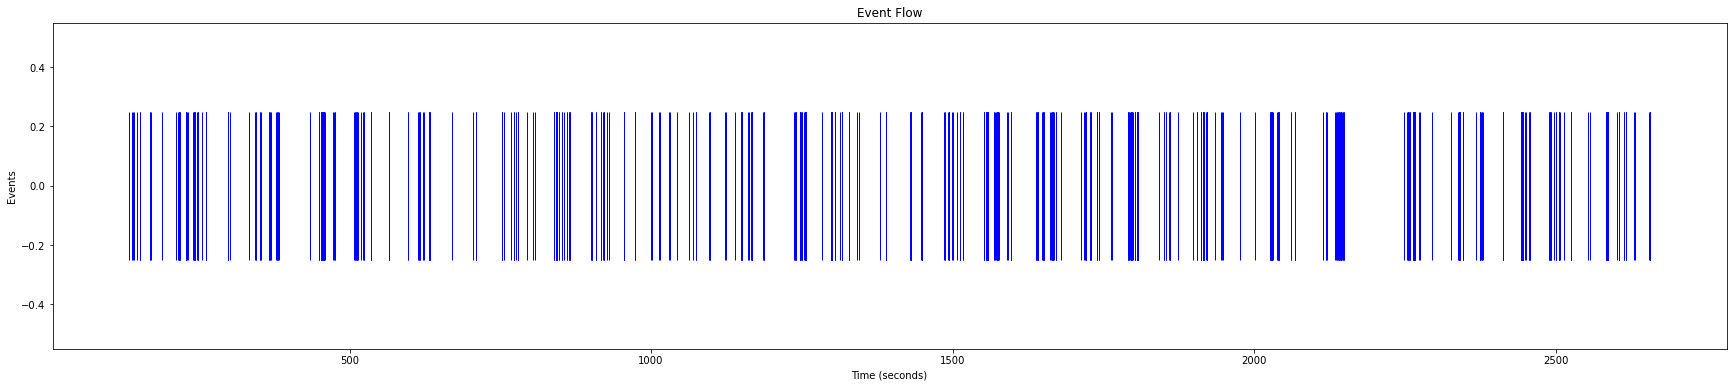

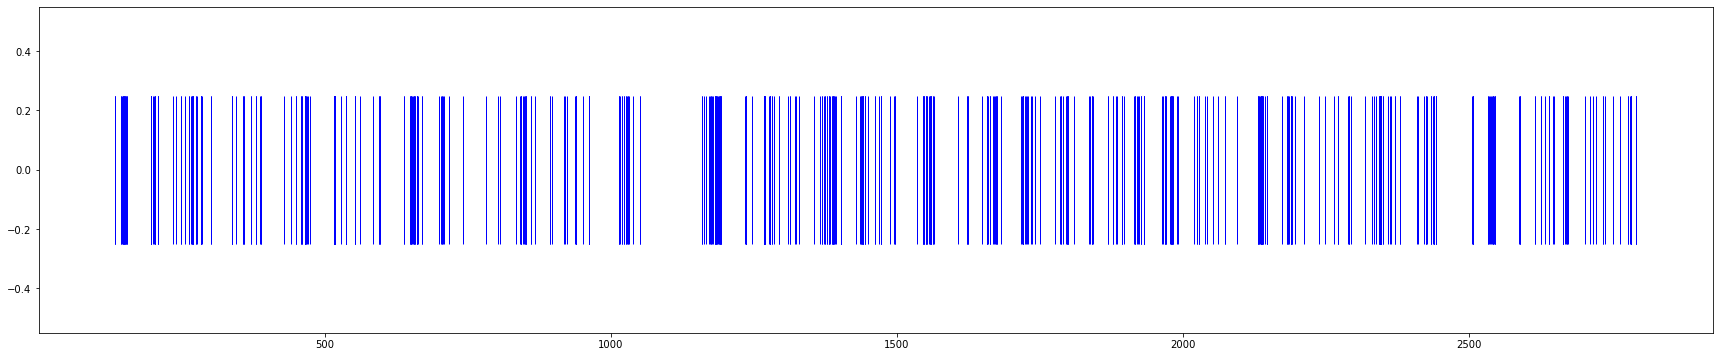

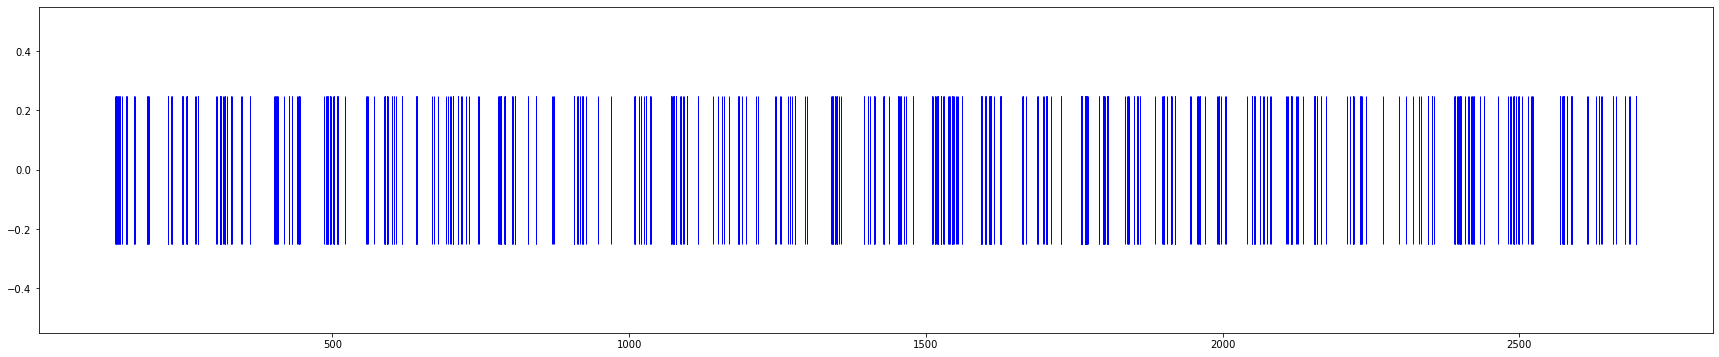

In [19]:
#分别导入三局file文件
sfile1 = ['003228401574225117203_1115935543.dem']
df_test1 = df[df['file'].isin(sfile1)]
sfile2 = ['003222992722193285431_0719199122.dem']
df_test2 = df[df['file'].isin(sfile2)]
sfile3 = ['003201673717864202280_0171883906.dem']
df_test3 = df[df['file'].isin(sfile3)]

# 绘制事件流图
plt.figure(figsize=(30, 6))
plt.eventplot(df_test1['seconds'], lineoffsets=0, linelengths=0.5, linewidths=1, color='blue')
plt.xlabel('Time (seconds)')  # 设置横轴标签
plt.ylabel('Events')  # 设置纵轴标签
plt.title('Event Flow')  # 设置图表标题
plt.show()  # 显示图表

plt.figure(figsize=(30, 6))
plt.eventplot(df_test2['seconds'], lineoffsets=0, linelengths=0.5, linewidths=1, color='blue')
plt.show() 

plt.figure(figsize=(30, 6))
plt.eventplot(df_test3['seconds'], lineoffsets=0, linelengths=0.5, linewidths=1, color='blue')
plt.show() 

In [20]:
#获取不同玩家ID的不同回合击杀人数，后手动输入至echart在线编辑模块（这里只以两回合为例）
sfile = ['003201673717864202280_0171883906.dem']
df_test = df[df['file'].isin(sfile)]
kill_count = df_test.groupby(['round','att_id'])["vic_id"].count()
kill_count = kill_count.head(18)
print(kill_count)

round  att_id           
1      76561198051040004    5
       76561198051106390    2
       76561198081341202    8
       76561198085893650    2
       76561198147933469    1
       76561198212678511    1
       76561198223006752    3
       76561198244806730    6
2      76561198051040004    9
       76561198051106390    1
       76561198081341202    1
       76561198085893650    2
       76561198087293525    1
       76561198123082770    2
       76561198147933469    3
       76561198212678511    2
       76561198223006752    4
       76561198244806730    1
Name: vic_id, dtype: int64


In [21]:
# 使用pivot_table生成伤害次数的透视表,后制作弦图
damage_table = pd.pivot_table(df_test, index='att_id', columns='vic_id', values='hp_dmg', aggfunc='count', fill_value=0)
# 导出为CSV文件
damage_table.to_csv('damage_table.csv')